# Week 3 Works (Subtract Data and Get Timeseries Plot)

## Get USA subset data from CHIRPS dataset

In [2]:
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 50.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 6.6 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp38-cp38-linux_x86_64.whl size=11127988 sha256=9223864ee59fcca85aa94b947ee7f7697f9c9752102db39d81b8693c401a2ce2
  Stored in directory: /root/.cache/pip/wheels/7c/ff/6f/09e4aa53f4e67d6498ef1d33dd4ea9c8c165817b9ddcc31d28
Successfully built cartopy


In [3]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.pyplot as plt
count_bord = cartopy.feature.NaturalEarthFeature('cultural','admin_0_boundary_lines_land','110m',facecolor='none')

### Import Data

In [ ]:
clim_chirp = xr.open_dataset('drive/Shareddrives/PSTAT197/chirps.2018.days_p05.nc')

In [4]:
clim_prism = xr.open_dataset('drive/Shareddrives/PSTAT197/PRISM_annual_daily_ppt_4km_2018.nc')

### Take a brief look

In [ ]:
clim_chirp.precip

<xarray.DataArray 'precip' (time: 365, latitude: 2000, longitude: 7200)>
[5256000000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

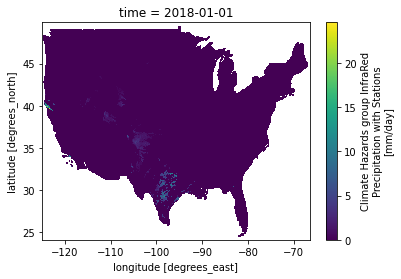

In [ ]:
clim_chirp.ppt[0,:,:].plot.pcolormesh()

In [ ]:
clim_prism.ppt

<xarray.DataArray 'ppt' (time: 273, latitude: 621, longitude: 1405)>
[238193865 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 49.92 49.87 49.83 49.79 ... 24.17 24.12 24.08
  * longitude  (longitude) float64 -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-09-30
Attributes:
    transform:   [-1.25020833e+02  4.16666667e-02  0.00000000e+00  4.99375000...
    crs:         +init=epsg:4269
    res:         [0.04166667 0.04166667]
    is_tiled:    0
    nodatavals:  -9999.0
    units:       mm

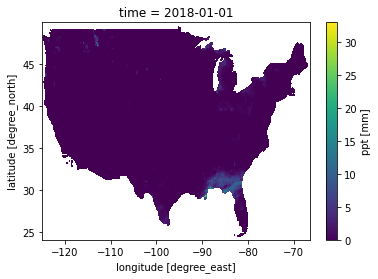

In [ ]:
clim_prism.ppt[0,:,:].plot.pcolormesh()

### Start Subtracting

#### Subtract CHIRPS data according to the maximum and minimum of longitude and latitude of the PRISM dataset 

latitude: 24.08 - 49.92
longtitude: -125 - -66.5

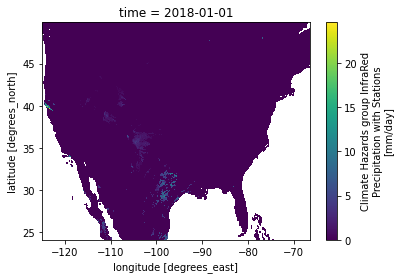

In [ ]:
clim_chirp_usa = clim_chirp.precip.sel(latitude = slice(24.08,49.92),longitude =slice(-125.0,-66.5))
clim_chirp_usa[0,:,:].plot.pcolormesh()

#### Find all the coordinates of null values in the PRISM dataset. Then set corresponding data(using nearest method) in CHIRPS dataset to null. This works because the density of data in PRISM dataset is larger then the density of data in CHIRPS dataset.

In [ ]:
#Get null values from PRISM dataset
#Ugly code, will run for an hour. REVISE IT!
import numpy as np
usa_list_lat = []
usa_list_long = []
for lat in clim_prism.ppt[0,:,:].latitude.values:
  for long in clim_prism.ppt[0,:,:].longitude.values:
    if all(np.isnan(clim_prism.ppt.sel(latitude = lat, longitude = long, method = "nearest").values)):
      usa_list_lat.append(lat)
      usa_list_long.append(long)

In [ ]:
#Set values outside usa to nan
for i in range(0, len(usa_list_lat)):
  point = clim_chirp_usa.sel(longitude=usa_list_long[i], latitude=usa_list_lat[i], method = 'nearest')
  clim_chirp_usa.loc[dict(longitude=point.longitude.values.tolist(), latitude=point.latitude.values.tolist())] = np.nan

#### Take a look

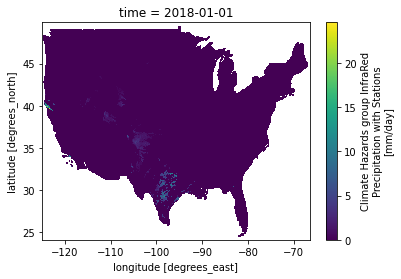

In [ ]:
clim_chirp_usa[0,:,:].plot.pcolormesh()

#### Save file

In [ ]:
chirp_usa_dataset = clim_chirp_usa.to_dataset(name = 'ppt')
chirp_usa_dataset.to_netcdf('chirp_usa_dataset.nc')



---



## Get Timeseries plot

In [5]:
clim_chirp = xr.open_dataset('drive/Shareddrives/PSTAT197/2018_data_usa/chirp_usa_dataset.nc')

Subtract clim_chirps data since PRISM data only contains data from January to September.

In [ ]:
chirps_data_to_september = clim_chirp.ppt.sel(time = slice('2018-01-01', '2018-09-30'))

In [ ]:
time_series_prism = []
for i in range(0, len(clim_prism.ppt.time)):
  time_series_prism.append(np.mean(clim_prism.ppt[i,:,:]).values.tolist())

In [ ]:
#This run for a longer time, don't know why...
time_series_chirp = []
for i in range(0, len(chirps_data_to_september.time)):
  time_series_chirp.append(np.mean(chirps_data_to_september[i,:,:]).values.tolist())

In [ ]:
import pandas as pd
prism_data = {'ppt': time_series_prism, 'time': clim_prism.ppt[:,0,0].time.values}
prism_dataframe = pd.DataFrame(prism_data)

In [ ]:
chirps_data = {'ppt': time_series_chirp, 'time': chirps_data_to_september[:,0,0].time.values}
chirps_dataframe = pd.DataFrame(chirps_data)

In [ ]:
all_data = {'CHIRPS': time_series_chirp, 'PRISM': time_series_prism, 'time': chirps_data_to_september[:,0,0].time.values}
all_dataframe = pd.DataFrame(all_data)

In [ ]:
import plotly.express as px
fig = px.line(prism_dataframe, x='time', y="ppt", title = "PRISM")
fig.update_yaxes(range=[0, 8]) 
fig.show()

In [ ]:
fig = px.line(chirps_dataframe, x='time', y="ppt", title = "CHIRPS")
fig.update_xaxes(range=['2018-01-01', '2018-09-30'])
fig.update_yaxes(range=[0, 8]) 
fig.show()

In [ ]:
fig = px.line(all_dataframe, x='time', y=["PRISM", "CHIRPS"], title = "Time Series Plot", color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_xaxes(range=['2018-01-01', '2018-09-30'])
fig.update_yaxes(range=[0, 8]) 
fig.show()



---



## Monthly plot 

In [25]:
clim_chirp = clim_chirp.ppt.sel(time = slice('2018-01-01', '2018-09-30'))
chirps_month = clim_chirp.groupby('time.month').mean('time')

In [9]:
prism_month = clim_prism.groupby('time.month').mean('time')

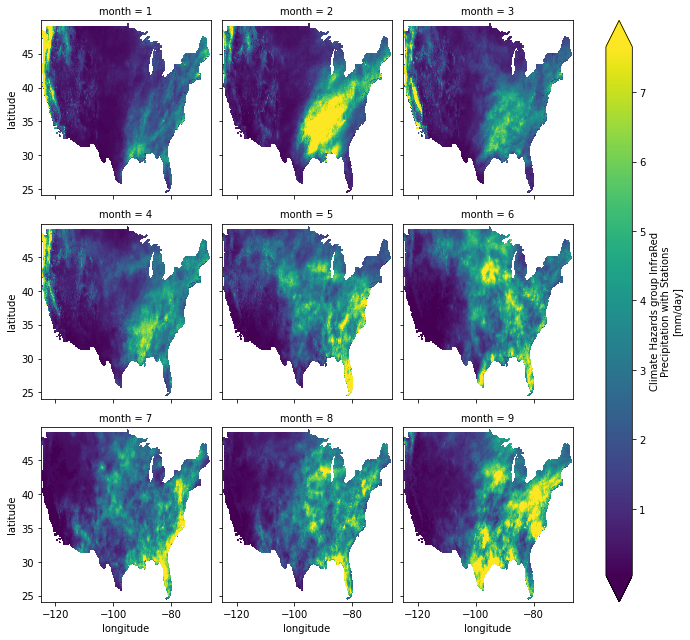

In [28]:
chirps_month.plot(x="longitude", y="latitude", col="month", col_wrap=3, robust=True)

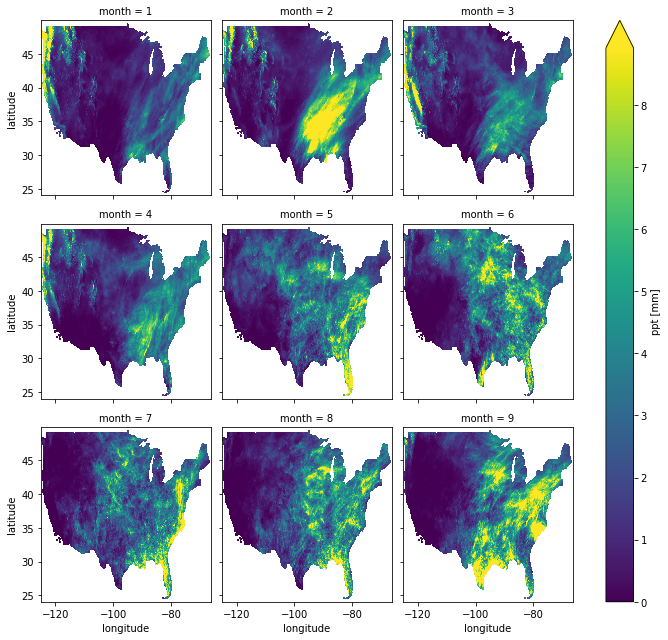

In [32]:
prism_month.ppt.plot(x="longitude", y="latitude", col="month", col_wrap=3, robust=True)



---



## Drafts, including Greg's seed codes

/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


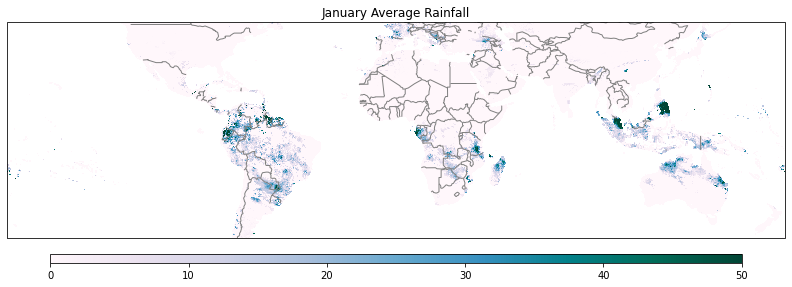

In [ ]:
#%% make a better map of the rainfall
projection = ccrs.PlateCarree()  #set the projection of the map
fig = plt.figure(figsize=(12,4))  #make the window for the graphics
ax = plt.axes([0.05,0.15,0.9,0.8],projection=projection)  # set the drawing area within the window
janmap = plt.pcolormesh(clim.longitude,clim.latitude,clim.precip[0,:,:],\
                        vmin=0, vmax=50, cmap='PuBuGn')
ax.set_title('January Average Rainfall') 
ax.add_feature(count_bord,edgecolor='gray')
cb = plt.colorbar(janmap,cax=fig.add_axes([0.1,0.09,0.8,0.03]), orientation='horizontal') #add colorbar

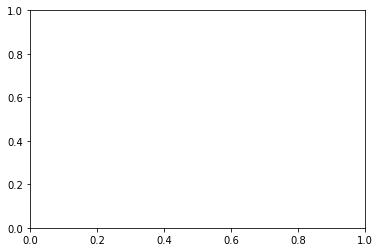

In [ ]:
ax.set_title('January Average Rainfall')  #put a title on the map
ax.coastlines(color='gray') #draw the coastlines in gray
#ax.add_feature(count_bord,edgecolor='gray') #draw the country boundaries
#ax.add_feature(cartopy.feature.OCEAN,color='skyblue',zorder=100) #color the oceans
cb = plt.colorbar(janmap,cax=fig.add_axes([0.1,0.09,0.8,0.03]), orientation='horizontal') #add colorbar

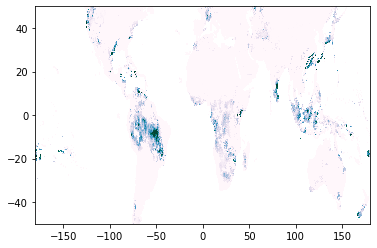

In [ ]:
janmap = plt.pcolormesh(clim.longitude,clim.latitude,clim.precip[0,:,:],\
                        vmin=0, vmax=50, cmap='PuBuGn')

<ipython-input-24-6a06becf6fbf>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cb = plt.colorbar(janmap,cax=fig.add_axes([0.1,0.09,0.8,0.03]), orientation='horizontal') #add colorbar


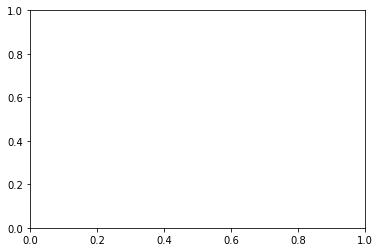

In [ ]:
ax.set_title('November Average Rainfall')  #put a title on the map
ax.coastlines(color='gray') #draw the coastlines in gray
#ax.add_feature(count_bord,edgecolor='gray') #draw the country boundaries
#ax.add_feature(cartopy.feature.OCEAN,color='skyblue',zorder=100) #color the oceans
cb = plt.colorbar(janmap,cax=fig.add_axes([0.1,0.09,0.8,0.03]), orientation='horizontal') #add colorbar

In [ ]:
monmap()
az.add_features
cb.ax.set_xtixklabels(['','',''])